## **Efficient net transfer learning to classify image of leaves disease**

This project use to classify image of leaves disease. The dataset contain 70295 images for training and 17572 images for validation belonging to 38 classes. 
The Efficent net information: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.  
The dataset information: https://www.kaggle.com/vipoooool/new-plant-diseases-dataset

Firstly, we need to download and create directory for the dataset.  
Directory:  
./data   
    /train  
    /valid  

In [ ]:

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fv9C7nbpT5IMuzwBf3uQvXd1ng76fvYI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1fv9C7nbpT5IMuzwBf3uQvXd1ng76fvYI" -O data.rar && rm -rf /tmp/cookies.txt
!unrar x -y data.rar


Streaming output truncated to the last 5000 lines.
Extracting  data/valid/Potato___Early_blight/41e155c4-eccf-4166-83cb-f110b2312c48___RS_Early.B 6985.JPG      89%  OK 
Extracting  data/valid/Potato___Early_blight/41e155c4-eccf-4166-83cb-f110b2312c48___RS_Early.B 6985_flipTB.JPG      89%  OK 
Extracting  data/valid/Potato___Early_blight/41eccd84-6a67-4b04-ae69-59c1bcf17728___RS_Early.B 7964.JPG      89%  OK 
Extracting  data/valid/Potato___Early_blight/41f4502c-34aa-45a5-b593-7191f7a62f96___RS_Early.B 8774_flipTB.JPG      89%  OK 
Extracting  data/valid/Potato___Early_blight/422fa1a6-d0f7-4634-9233-0d002ff139ae___RS_Early.B 7218.JPG      89%  OK 
Extracting  data/valid/Potato___Early_blight/422fa1a6-d0f7-4634-9233-0d002ff139ae___RS_Early.B 7218_flipTB.JPG      89%  OK 
Extracting  data/valid/Potato___Early_blight/425e5f26-56b0-404d-b537-dc3353ecee09___RS_Early.B 7058_flipTB.JPG      89%  OK 
Extracting  data/valid/Potato___

We perform normalization and some data augmentation include random rotation, random constract...

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


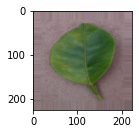

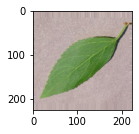

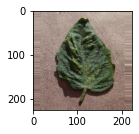

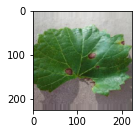

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import numpy as np
batch_size = 16

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

IMG_SIZE = 224
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255,featurewise_center=True,
        featurewise_std_normalization=True)


train_generator = train_datagen.flow_from_directory(
        'data/train',  
        target_size=(224, 224),  
        batch_size=batch_size,
        class_mode= "categorical")  


validation_generator = test_datagen.flow_from_directory(
        'data/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode= "categorical")



x= train_generator.next()
for i in range(0,4):
    ax = plt.subplot(2, 2, i + 1)
    image = x[0][i]
    plt.imshow(image)
    plt.show()

**Transfer learning**  

First step to transfer learning is to freeze all layers and train only the top layers. For this step, a relatively large learning rate (1e-2) can be used. We use Checkpoint to avoid overfitting and save the best model. 

In [ ]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
base_model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False


x = base_model(x)


x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(38, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

epochs = 150  # @param {type: "slider", min:50, max:200}
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.summary()


hist = model.fit_generator(
        train_generator,
        steps_per_epoch=1000 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks_list,
        validation_steps=300 // batch_size)


Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
pred (Dense)                 (None, 38)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


62/62 [==============================] - 22s 242ms/step - loss: 3.8449 - accuracy: 0.2428 - val_loss: 7.1022 - val_accuracy: 0.0208

Epoch 00001: val_accuracy improved from -inf to 0.02083, saving model to weights.best.hdf5
Epoch 2/150
62/62 [==============================] - 14s 223ms/step - loss: 2.6494 - accuracy: 0.5253 - val_loss: 10.4439 - val_accuracy: 0.0243

Epoch 00002: val_accuracy improved from 0.02083 to 0.02431, saving model to weights.best.hdf5
Epoch 3/150
62/62 [==============================] - 14s 223ms/step - loss: 2.0032 - accuracy: 0.6357 - val_loss: 17.4439 - val_accuracy: 0.0174

Epoch 00003: val_accuracy did not improve from 0.02431
Epoch 4/150
62/62 [==============================] - 14s 223ms/step - loss: 2.1584 - accuracy: 0.6846 - val_loss: 18.2732 - val_accuracy: 0.0174

Epoch 00004: val_accuracy did not improve from 0.02431
Epoch 5/150
62/62 [==============================] - 14s 223ms/step - loss: 1.8889 - accuracy: 0.7461 - val_loss: 10.5062 - val_accura

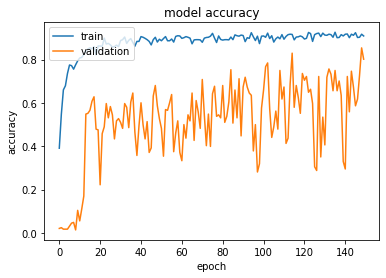

In [ ]:



def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

The second step is to unfreeze a number of layers and fit the model using smaller learning rate.

In [ ]:


model.load_weights("weights.best.hdf5")
for layer in base_model.layers:
    layer.trainable = True


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)



model.summary()
epochs = 50  # @param {type: "slider", min:8, max:50}
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=700 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks_list,
        validation_steps=200 // batch_size)

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
pred (Dense)                 (None, 38)               

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
43/43 [==============================] - 20s 275ms/step - loss: 0.7651 - accuracy: 0.9077 - val_loss: 1.2470 - val_accuracy: 0.8646

Epoch 00001: val_accuracy improved from 0.85417 to 0.86458, saving model to weights.best.hdf5
Epoch 2/50
43/43 [==============================] - 11s 246ms/step - loss: 0.8496 - accuracy: 0.9009 - val_loss: 1.0174 - val_accuracy: 0.8542

Epoch 00002: val_accuracy did not improve from 0.86458
Epoch 3/50
43/43 [==============================] - 11s 246ms/step - loss: 0.4260 - accuracy: 0.9489 - val_loss: 1.0257 - val_accuracy: 0.8646

Epoch 00003: val_accuracy did not improve from 0.86458
Epoch 4/50
43/43 [==============================] - 11s 247ms/step - loss: 0.5531 - accuracy: 0.9402 - val_loss: 0.9615 - val_accuracy: 0.8750

Epoch 00004: val_accuracy improved from 0.86458 to 0.87500, saving model to weights.best.hdf5
Epoch 5/50
43/43 [==============================] - 11s 250ms/step - loss: 0.9250 - accuracy: 0.9046 - val_loss: 1.0007 - val_

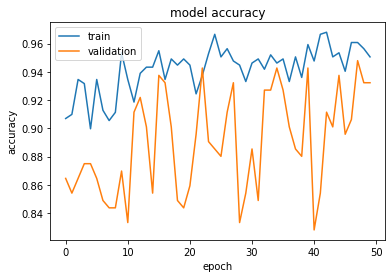

In [ ]:
plot_hist(hist)

The model have the accuracy of: 94.7%

References: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/  
https://keras.io/guides/transfer_learning/  
